In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import glob
import os

# Specify the directory containing the CSV files
directory_path = '/content/drive/MyDrive/END_RESULT_EFFICIENCY'

# Using glob to find all CSV files in the directory
all_files = glob.glob(os.path.join(directory_path, "*.csv"))

# Read and concatenate all CSV files into a single DataFrame
df = pd.concat([pd.read_csv(file) for file in all_files])

# Display the first few rows of the combined DataFrame
df.head()

,Unnamed: 0.1,Unnamed: 0,timedelta,symbol,commence,timestamp,method,y_pred,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,hours,time,efficiency,bin
0,0,0,0 days 06:27:00,1INCH-USD,2024-07-10 18:33:19,2024-07-10 18:33:19,KNeighborsClassifier(),1,0.168498,0.000621,0.116856,0.004737,-0.003651,39,6.450000,1.720636e+09,0,0
1,1,0,0 days 04:05:00,1INCH-USD,2024-07-11 08:29:02,2024-07-11 08:29:02,KNeighborsClassifier(),1,0.072252,-0.000046,0.048731,-0.000309,-0.004673,5,4.083333,1.720687e+09,0,0
2,2,0,0 days 08:25:00,1INCH-USD,2024-07-11 03:30:00,2024-07-11 03:30:00,KNeighborsClassifier(),1,0.044469,-0.000404,0.031256,-0.002722,-0.008970,5,8.416667,1.720669e+09,0,0
3,3,0,0 days 05:06:00,1INCH-USD,2024-07-10 18:02:38,2024-07-10 18:02:38,KNeighborsClassifier(),1,-0.118787,0.001345,-0.088057,0.009693,-0.002421,7,5.100000,1.720635e+09,0,0
4,4,0,0 days 16:14:00,1INCH-USD,2024-07-10 20:20:40,2024-07-10 20:20:40,KNeighborsClassifier(),1,-0.019467,0.001214,-0.019575,0.009160,-0.010941,6,16.233333,1.720643e+09,0,0


In [24]:
# Display the distribution of the 'bin' column
bin_distribution = df['bin'].value_counts()
print(bin_distribution)

bin
1    1068
0    1066
Name: count, dtype: int64


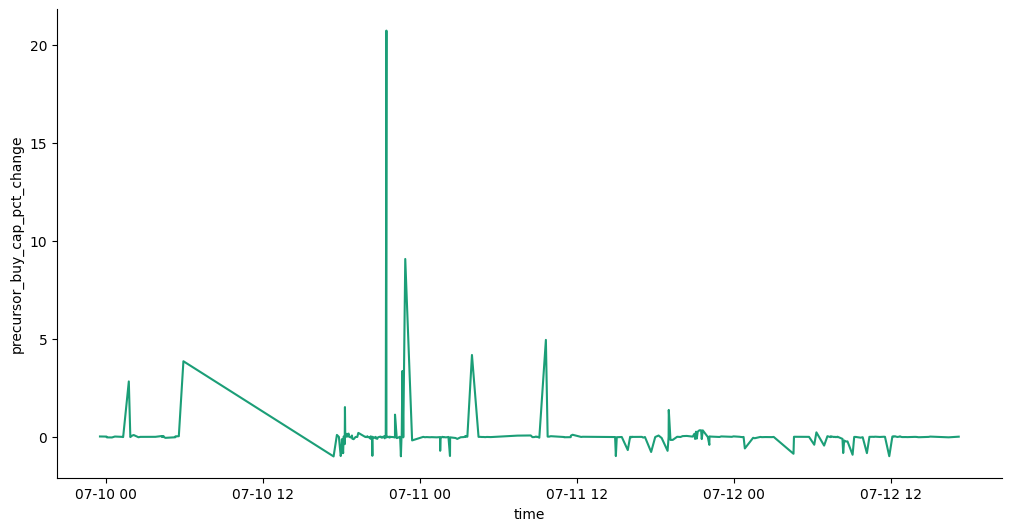

In [19]:
# @title time vs precursor_buy_cap_pct_change

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['precursor_buy_cap_pct_change']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('precursor_buy_cap_pct_change')

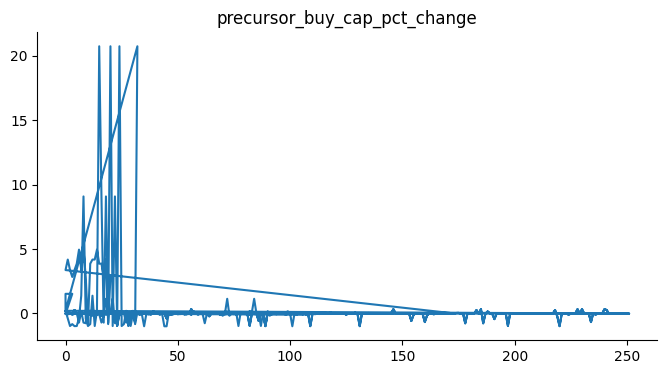

In [17]:
# @title precursor_buy_cap_pct_change

from matplotlib import pyplot as plt
df['precursor_buy_cap_pct_change'].plot(kind='line', figsize=(8, 4), title='precursor_buy_cap_pct_change')
plt.gca().spines[['top', 'right']].set_visible(False)

# Model with Prediction error




In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

# Define the columns you want to keep in X_train

keepable = ['precursor_buy_cap_pct_change',
'precursor_ask_cap_pct_change',
'precursor_bid_vol_pct_change',
'precursor_ask_vol_pct_change',
'sum_change', 'length', 'time']

# Initialize StandardScaler
scaler = StandardScaler()

# Initialize NCA
nca = NCA(random_state=42)

# Apply NCA for feature selection
nca.fit(df[keepable], df['bin'])
X_transformed = nca.transform(df[keepable])

# Split the transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df['bin'], test_size=0.2, random_state=42)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier on the scaled data
knn.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred = knn.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

Accuracy: 0.8009367681498829


## Model With Hyper parameter Tuning to have less error

In [30]:
# Initialize StandardScaler
scaler = StandardScaler()

# Initialize NCA
nca = NCA(random_state=42)

# Apply NCA for feature selection
nca.fit(df[keepable], df['bin'])
X_transformed = nca.transform(df[keepable])

# Split the transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df['bin'], test_size=0.2, random_state=42)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# Define the parameter grid for Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the Grid Search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

# Make predictions on the test data using the best estimator
y_pred = best_knn.predict(X_test_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy and best parameters
print('Best Parameters:', best_params)
print('Accuracy after tuning:', accuracy)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Accuracy after tuning: 0.9508196721311475
